In [70]:
%load_ext autoreload
%autoreload 2

In [268]:
import chromadb
from chromadb.utils import embedding_functions
import embedClustering
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import tqdm

from sklearn.cluster import HDBSCAN

import numpy as np
from sklearn.cluster import DBSCAN
import hdbscan as native_hdbscan

#from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from SonarEmbeddingFunction import SonarEmbeddingFunction
import torch
from tqdm import tqdm

In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline


In [269]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
embedding_func = SonarEmbeddingFunction()

In [72]:
CHROMA_DATA_PATH = "chroma_data/"
COLLECTION_NAME = "news_articles"

client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

In [73]:
collection = client.get_collection(COLLECTION_NAME, embedding_function=embedding_func)

In [74]:
collection.peek(0)['embeddings'][0]

array([ 0.00958172, -0.00900653,  0.00399394, ...,  0.01164579,
       -0.01475414,  0.00666587])

In [75]:
query_results = collection.query(
    query_texts=["Tuesday Briefing"],
    n_results=1
)
query_results

{'ids': [['id126']],
 'embeddings': None,
 'documents': [['Tuesday Briefing']],
 'uris': None,
 'data': None,
 'metadatas': [[{'lemmatized_text': 'u election tied two week go american head poll donald trump kamala harris running neck neck nate cohn times chief political analyst writes harris trump essentially tied times polling average five critical battleground state pennsylvania michigan nevada wisconsin north carolina neither candidate ahead single point several state neither candidate ahead twotenths percentage point lastditch hunt undecided voter campaign desperately hunting voter still grab camp think many younger black latino harris team also eyeing white collegeeducated woman harris campaigned former representative liz cheney wyoming event aimed republican woman voter fraud early voting underway many state trump acknowledged seen sign cheating even continued sow doubt integrity election know side good said democrat seen',
    'link': 'https://www.nytimes.com/2024/10/22/briefing

In [76]:
embeddings = np.array(collection.get(include=['embeddings'])['embeddings'])
len(embeddings), len(embeddings[0])

(158, 1024)

In [77]:
documents = np.array(collection.get(include=['documents'])['documents'])
article = np.array([meta["text"] for meta in collection.get(include=['metadatas'])["metadatas"]])


In [78]:
documents[0]

'IDF soldiers should refuse orders that may be war crimes, Israeli ex-security adviser tells BBC'

In [80]:
article[0]

'IDF soldiers should refuse orders that may be war crimes Israeli exsecurity adviser tells BBC IDF could be committing war crimes in northern Gaza says Eran Etzion As someone who served four Israeli prime ministers and was deputy head of the countrys National Security Council Eran Etzions judgement was trusted at the highest levels of the state A longstanding critic of Prime Minister Benjamin Netanyahu he is also someone whose years of public service earned him widespread respect But now Mr Etzion a former soldier himself is warning that Israels military the Israel Defense Forces IDF might be committing war crimes in northern Gaza And he is suggesting that officers and troops should reject illegal orders They should refuse If a soldier or an officer is expected to commit something that might be suspected as a war crime they must refuse Thats what I would do if I were a soldier Thats what I think any Israeli soldier should do he tells me We are sitting on the balcony of his home in Shor

In [81]:
embeddings[0]

array([ 0.00958172, -0.00900653,  0.00399394, ...,  0.01164579,
       -0.01475414,  0.00666587])

In [82]:
reduced_embeddings = embedClustering.tsneReduceEMB(embeddings)

In [83]:
reduced_embeddings[:10]

array([[ 0.11276525,  2.4617217 ],
       [ 0.435027  , -3.4425204 ],
       [ 5.7643237 , -0.28362584],
       [-1.7332722 ,  0.5097476 ],
       [-0.3448544 , -1.3560345 ],
       [ 1.5918823 ,  3.6918967 ],
       [ 4.563619  ,  2.274478  ],
       [ 0.8948862 , -1.4654973 ],
       [-1.8115269 ,  3.7909982 ],
       [-0.04655565, -1.077337  ]], dtype=float32)

In [84]:
k_nearest_neighbors = 3

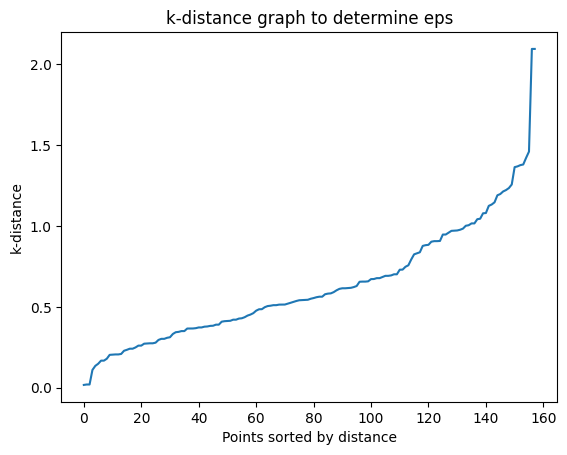

1.3799498319830414

In [85]:
optimal_eps = embedClustering.findEPS(reduced_embeddings, k=k_nearest_neighbors)
optimal_eps


In [232]:
labels, n_clusters, n_noise = embedClustering.hdbscanEMB(reduced_embeddings, min_samples=3)

Estimated number of clusters: 6
Estimated number of noise points: 90


In [2]:
clusterer = native_hdbscan.HDBSCAN(min_samples=1, cluster_selection_epsilon=0.1)
labels = clusterer.fit_predict(reduced_embeddings)

# max_label = labels.max()

# # Create a new array for adjusted labels
# labels = labelsb.copy()

# # Assign unique cluster labels to points that were marked as noise (-1)
# for i, label in enumerate(labels):
#     if label == -1:  # Noise point
#         max_label += 1
#         labels[i] = max_label
    
clusterer.condensed_tree_.plot(select_clusters=True)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise= list(labels).count(-1)
persistence_scores = clusterer.cluster_persistence_

# Find the maximum existing cluster label (to assign new labels for noise points)

#print("Persistence Score:", persistence_scores)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

NameError: name 'native_hdbscan' is not defined

In [244]:
labels, n_clusters, n_noise = embedClustering.dbscanEMB(reduced_embeddings, eps=0.37, min_samples=2)

Estimated number of clusters: 32
Estimated number of noise points: 69


In [249]:
tsne_df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['title'] =  [title for title in documents]
tsne_df['cluster'] = labels


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',
    hover_data=['title'],
    #color_continuous_scale=px.colors.diverging.BrBG
)
fig.show()

In [1]:
fig.write_html("hdbscan.html")

NameError: name 'fig' is not defined

In [250]:
print(labels[:10])

[-1  3 -1  2  4 -1 -1  4 -1  4]


In [251]:
print(n_clusters)

8


In [252]:
len(embeddings), len(embeddings[0])

(158, 1024)

In [253]:
len(labels)

158

In [254]:
#create array of n_clusters empty lists
index_cluster = [[] for i in range(n_clusters)]
print(index_cluster)

[[], [], [], [], [], [], [], []]


In [255]:
len(index_cluster)

8

In [256]:
index_cluster[3] 

[]

In [257]:
for i in range(len(labels)):
    label = labels[i]
    if label != -1:
        index_cluster[label].append(i)
    if label == 1496:
        print("found at:", i)
index_cluster[2]

[3, 80, 82, 94, 109, 125]

In [258]:
len(index_cluster)

8

In [259]:
clustered_embeddings = []

for i in index_cluster:
    cluster_e = []
    for j in i:
        cluster_e.append(embeddings[j])
    average_cluster_e = sum(cluster_e) / len(cluster_e)
    clustered_embeddings.append(average_cluster_e)
    
clustered_embeddings = np.array(clustered_embeddings)


In [260]:
clustered_embeddings.shape

(8, 1024)

In [261]:
embeddings.shape

(158, 1024)

In [263]:
print(clustered_embeddings.shape)
print(type(clustered_embeddings))
clustered_embeddings = torch.from_numpy(clustered_embeddings.astype(np.float32))
print(clustered_embeddings.shape)
print(type(clustered_embeddings))

(8, 1024)
<class 'numpy.ndarray'>
torch.Size([8, 1024])
<class 'torch.Tensor'>


In [264]:
s_clustered_embeddings = clustered_embeddings[:2]

In [265]:
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline


In [266]:
vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=device)

In [267]:
reconstructed = vec2text_model.predict(clustered_embeddings, target_lang="eng_Latn", progress_bar=True, max_seq_len=32)

print(reconstructed)


  0%|          | 0/2 [00:00<?, ?it/s]

["Trumps Heroes follow to Acra's announcement", "What Israel's Foreign Ministers and Foreign Ministers", "China Will North Korea's Force in Ukraine", 'Five percent killed in attack on Turkish airline', 'President Trump sends a message to President Trump', "PM Xi's and PM Modi's Meeting to Greet between the Countries", 'American Renaissance saves money, gets messed up between founders', 'British and Russian Cooperation']


In [37]:
clustered_embeddings = clustered_embeddings.numpy()

In [38]:
print(type(embeddings))
print(type(clustered_embeddings))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [39]:
print(sum(embeddings[0])/len(embeddings[0]))
print(sum(clustered_embeddings[0])/len(clustered_embeddings[0]))

8.82665064949606e-06
3.42779240058988e-05


In [45]:
e_1 = len(embeddings)
print(e_1)
ce_1 =  len(clustered_embeddings)
print(ce_1)
print()
print("total len:", e_1 + ce_1)
print()
all_embeddings = np.concatenate((embeddings, clustered_embeddings), axis=0)
print(all_embeddings.shape)

18013
1454

total len: 19467

(19467, 1024)


In [46]:
all_reduced_embeddings  = embedClustering.tsneReduceEMB(all_embeddings)

In [86]:
reduced_clustered_embeddings = all_reduced_embeddings[e_1:]
print(reduced_clustered_embeddings.shape)

reduced_first_embeddings = all_reduced_embeddings[:e_1]
print(reduced_first_embeddings.shape)

(1454, 2)
(18013, 2)


In [82]:
reduced_clustered_embeddings[:10]

array([[-64.59525   , -22.837395  ],
       [-63.784157  ,  -0.41191578],
       [-41.575294  , -37.33531   ],
       [-48.6857    , -33.26639   ],
       [-39.712646  ,  47.19744   ],
       [-55.88133   ,  18.239592  ],
       [-36.901573  , -44.73168   ],
       [-47.938927  , -13.464346  ],
       [-57.956944  ,  10.699148  ],
       [-43.97452   , -26.740438  ]], dtype=float32)

In [83]:
k_nearest_neighbors = 3

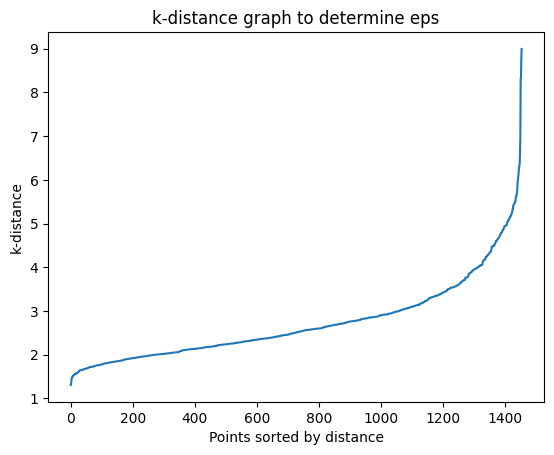

5.086334995575122

In [87]:
optimal_eps = embedClustering.findEPS(reduced_clustered_embeddings, k=k_nearest_neighbors)
optimal_eps


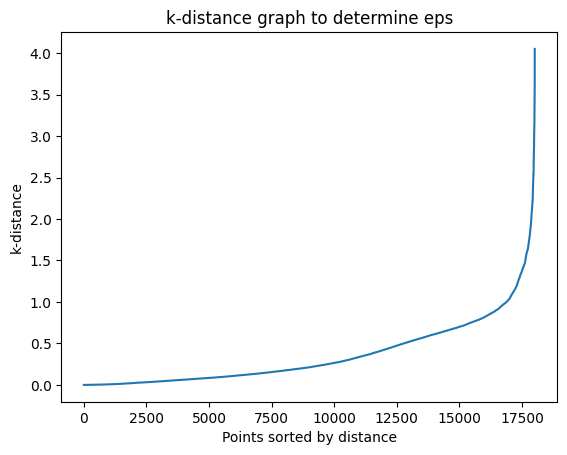

2.8413170219747292

In [88]:
first_optimal_eps = embedClustering.findEPS(reduced_first_embeddings, k=k_nearest_neighbors)
first_optimal_eps

In [151]:
labels_clustered, n_clusters, n_noise = embedClustering.hdbscanEMB(reduced_clustered_embeddings, min_samples=k_nearest_neighbors)

Estimated number of clusters: 14
Estimated number of noise points: 245


In [1]:
db = HDBSCAN(min_samples=k_nearest_neighbors).fit(embeddings)

labels_first = db.labels_

n_clusters = len(set(labels_first)) - (1 if -1 in labels_first else 0)
n_noise = list(labels_first).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

NameError: name 'HDBSCAN' is not defined

In [143]:
len(labels_clustered)

1454

In [144]:
len(labels_first)

18013

In [145]:
cluster_prev = list(range(len(clustered_embeddings)))
len(cluster_prev)

1454

In [146]:
len(reduced_clustered_embeddings)

1454

In [147]:

tsne_df = pd.DataFrame(reduced_clustered_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = [doc[:40] for doc in reconstructed]
tsne_df['cluster'] = cluster_prev
#Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish

#selected_languages = ['af', 'am', 'ast', 'arz', 'ar', 'ary', 'ckb', 'cy', 'da', 'de', 'fr', 'fur', 'din', 'el', 'eo', 'et', 'eu', 'fo', 'fa', 'is', 'it', 'jv', 'ja', 'kab', 'ka', 'kn', 'ks', 'kk', 'th', 'km', 'azb', 'az', 'ba', 'ban', 'be', 'bn', 'bh', 'bo', 'bs', 'bg', 'ca', 'ceb', 'cs', 'ckb', 'fi', 'gd', 'ga', 'gl', 'gn', 'gu', 'ht', 'ha', 'he', 'hi', 'hr', 'hu', 'hy', 'ig', 'ilo', 'id', 'ky', 'ko', 'ku', 'lo', 'lv', 'lij', 'li', 'lt', 'lmo', 'lb']

#tsne_df = tsne_df[tsne_df["language"].isin(selected_languages)]


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',    
    hover_data=['text'],
    title="Average Clustered Embeddings"
    #color_continuous_scale=px.colors.diverging.BrBG
)


fig.show()

In [148]:
#fig.write_html("./exportClusters/interactive_plot1_ace_sonar.html")


In [149]:

tsne_df = pd.DataFrame(reduced_first_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = [doc[:40] for doc in documents]
tsne_df['cluster'] = labels_first
#Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish

#selected_languages = ['af', 'am', 'ast', 'arz', 'ar', 'ary', 'ckb', 'cy', 'da', 'de', 'fr', 'fur', 'din', 'el', 'eo', 'et', 'eu', 'fo', 'fa', 'is', 'it', 'jv', 'ja', 'kab', 'ka', 'kn', 'ks', 'kk', 'th', 'km', 'azb', 'az', 'ba', 'ban', 'be', 'bn', 'bh', 'bo', 'bs', 'bg', 'ca', 'ceb', 'cs', 'ckb', 'fi', 'gd', 'ga', 'gl', 'gn', 'gu', 'ht', 'ha', 'he', 'hi', 'hr', 'hu', 'hy', 'ig', 'ilo', 'id', 'ky', 'ko', 'ku', 'lo', 'lv', 'lij', 'li', 'lt', 'lmo', 'lb']

#tsne_df = tsne_df[tsne_df["language"].isin(selected_languages)]


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',    
    hover_data=['text'],
    title="Average Clustered Embeddings"
    #color_continuous_scale=px.colors.diverging.BrBG
)


fig.show()

In [103]:
len(reconstructed)

1454

In [129]:
reconstructed[1496]

IndexError: list index out of range